In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from enum import Enum
from typing import NamedTuple
from time import sleep
# Third-Party Library Imports
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import xarray as xr
from scipy.stats import spearmanr

# Plotting imports
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))

import utils
import plotting_utils
import climate_utils
import stats
import time_of_emrgence_calc as toe
import toe_constants as toe_const

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")

Matplotlib created a temporary config/cache directory at /jobfs/116060590.gadi-pbs/matplotlib-_mfd109o because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

In [70]:
# client.close()

In [69]:
from dask.distributed import Client
client = Client(threads_per_worker=1, n_workers=6) #n_workers=2
# Scale the client to have n workers workers
# client.cluster.scale(28)
client

 - State start
 -   Scheduler at:     tcp://127.0.0.1:34871
 -   dashboard at:         /proxy/8787/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:45015'
 -         Start Nanny at: 'tcp://127.0.0.1:36551'
 -         Start Nanny at: 'tcp://127.0.0.1:45691'
 -         Start Nanny at: 'tcp://127.0.0.1:37841'
 -         Start Nanny at: 'tcp://127.0.0.1:43071'
 -         Start Nanny at: 'tcp://127.0.0.1:37005'
 - Register worker <WorkerState 'tcp://127.0.0.1:38913', name: 2, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:38913
 - Starting established connection to tcp://127.0.0.1:46046
 - Register worker <WorkerState 'tcp://127.0.0.1:33591', name: 5, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:33591
 - Starting established connection to tcp://127.0.0.1:46032
 - Register worker <WorkerState 'tcp://127.0.0.1:45947', name: 4, status: init, memory: 0, processing: 0>

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 6
Total threads: 6,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34871,Workers: 6
Dashboard: /proxy/8787/status,Total threads: 6
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:41309,Total threads: 1
Dashboard: /proxy/46051/status,Memory: 41.86 GiB
Nanny: tcp://127.0.0.1:45015,


In [5]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'
os.listdir(os.path.join(ROOT_DIR, 'best'))

['Complete_TAVG_LatLong1.nc',
 'best_mask_old.zarr',
 'best_mask.zarr',
 'Land_and_Ocean_LatLong1_time_chunk.zarr',
 'Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [6]:
best_ds_raw = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1_time_chunk.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)

best_ds_raw['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds_raw.time.values))
best_ds = best_ds_raw.copy(deep=True)['temperature']
best_ds = best_ds.resample(time='Y').mean()
best_ds = best_ds.compute()

0.3.0


In [7]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds.where(best_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)>
array([[[  nan, ...,   nan],
        ...,
        [  nan, ...,   nan]],

       ...,

       [[  nan, ...,   nan],
        ...,
        [-0.03, ..., -0.03]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00
Attributes: (5)

In [8]:
base_period_ds_count = base_period_ds.count(dim='time')

In [9]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
data_availability_mask = xr.where(base_period_ds_count>=40, 1, 0)
data_availability_mask

<xarray.DataArray 'temperature' (lat: 180, lon: 360)>
array([[0, ..., 0],
       ...,
       [0, ..., 0]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [10]:
# Apply the mask to both the base period and the full dataset
best_ds = best_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

In [11]:
# Resetting the anomlies to 1850
best_ds = best_ds - base_period_ds.mean(dim='time')
base_period_ds = base_period_ds - base_period_ds.mean(dim='time')

# Sample Calculation

In [12]:
selection_dict = dict(lat=-38, lon=145, method='nearest')

In [13]:
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)>
array([[[nan, ..., nan],
        ...,
        [nan, ..., nan]],

       ...,

       [[nan, ..., nan],
        ...,
        [nan, ..., nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00

In [14]:
base_arr = base_period_ds.sel(**selection_dict).squeeze()#.values

In [15]:
arr_best =  best_ds.sel(**selection_dict).squeeze()
arr_best = arr_best.isel(time=slice(130, 160))
# arr_best = arr_best.isel(time=slice(None, 50))

In [16]:
np.take(arr_best.time.values, [0, -1])

array([cftime.DatetimeGregorian(1980, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2009, 12, 31, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)

In [17]:
np.take(base_arr.time.values, [0, -1])

array([cftime.DatetimeGregorian(1850, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1899, 12, 31, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)

In [18]:
arr_best = arr_best.values
base_arr = base_arr.values

In [19]:
arr_best

array([ 0.78,  0.92,  0.71,  0.48, -0.15,  0.34, -0.16,  0.14,  1.19,
        0.51,  0.83,  0.54, -0.02,  0.45,  0.21, -0.13, -0.25,  0.7 ,
        0.5 ,  0.96,  0.94,  0.91,  0.87,  0.73,  0.52,  1.02,  0.79,
        1.63,  0.75,  1.36], dtype=float32)

In [20]:
# np.testing.assert_equal(arr_best, base_arr)

In [21]:
np.nanmin(arr_best), np.nanmin(base_arr)

(-0.25295871, -0.43993783)

In [22]:
np.nanmax(arr_best), np.nanmax(base_arr)

(1.6317903, 0.6432928)

In [23]:
step = 0.15

In [24]:
bins = np.arange(-3, 3+step, step)

In [25]:
def get_rel_freq(arr, bins):
    arr = arr[np.isfinite(arr)]
    counts, _ = np.histogram(arr, bins=bins, density=False)
    rel_freq = counts/len(arr)
    return rel_freq

In [26]:
rel_freq_base = get_rel_freq(base_arr, bins)
rel_freq_best = get_rel_freq(arr_best, bins)

In [27]:
np.sum(rel_freq_base)

1.0

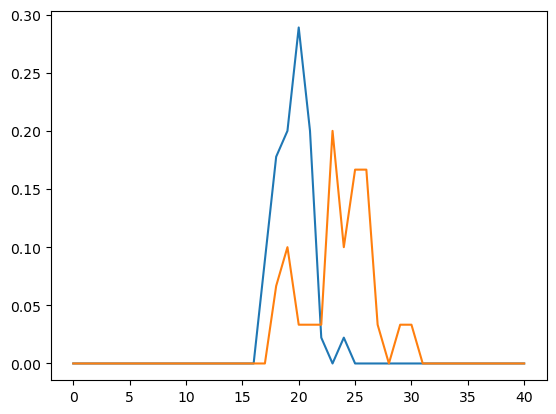

In [28]:
plt.plot(rel_freq_base)
plt.plot(rel_freq_best)

In [29]:
rel_freq_base == rel_freq_best

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

<function matplotlib.pyplot.show(close=None, block=None)>

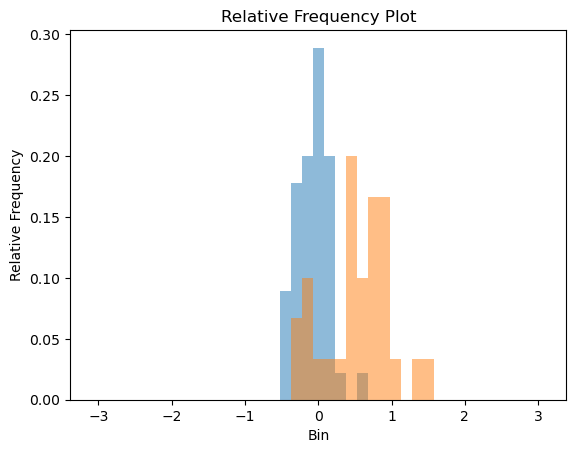

In [30]:

# plot the relative frequency
plt.bar(bins[:-1], rel_freq_base, alpha=0.5, width=step)
plt.bar(bins[:-1], rel_freq_best, alpha=0.5, width=step)

plt.xlabel('Bin')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Plot')
# plt.xticks(range(len(rel_freq)), ['[0, 2)', '[2, 4)', '[4, 6)'])
plt.show

In [31]:
freq_stack =np.array([rel_freq_base, rel_freq_best]) 
freq_stack.shape

(2, 41)

In [32]:
freq_stack = freq_stack.transpose()

In [33]:
freq_min = np.nanmin(freq_stack, axis=1)

In [34]:
freq_min_sum_percent = np.sum(freq_min) * 100

In [35]:
freq_min_sum_percent

27.77777777777778

## Fractional Geometric Area

In [36]:
from scipy.stats import gaussian_kde

In [37]:
bmax = np.nanmax(np.concatenate([base_arr, arr_best]))
bmin = np.nanmin(np.concatenate([base_arr, arr_best]))
bmin,  bmax = -3, 3

In [86]:
x = np.linspace(bmin, bmax, 10)

In [87]:
base_arr = base_arr[np.isfinite(base_arr)]
arr_best = arr_best[np.isfinite(arr_best)]

In [88]:
kde1 = gaussian_kde(base_arr)
kde2 = gaussian_kde(arr_best)

In [89]:
kde_vals1 = kde1(x)
kde_vals2 = kde2(x)

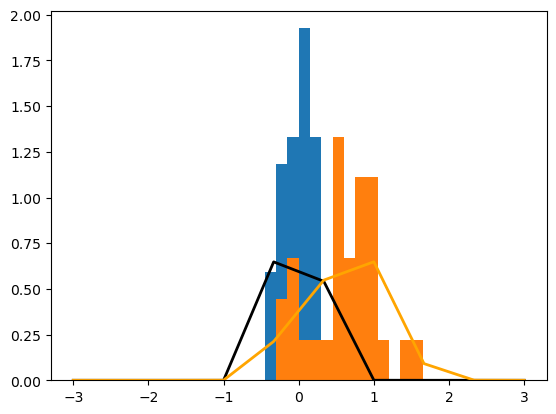

In [90]:
plt.plot(x, kde_vals1, 'k', linewidth=2)
plt.plot(x, kde_vals2, 'orange', linewidth=2)

plt.hist(base_arr, bins=np.arange(bmin, bmax, 0.15), density=True);
plt.hist(arr_best, bins=np.arange(bmin, bmax, 0.15), density=True);

In [43]:
overlap_shape = np.min(np.vstack([kde_vals2,kde_vals1]), axis=0)

In [44]:
overlap_area = np.trapz(overlap_shape, x)

In [45]:
overlap_percent = overlap_area * 100
overlap_percent

35.390983746879826

# Apply As ufunc

In [46]:
CHUNKS_FOR_PVALUE_TESTS =  {'lat':30, 'lon':30, 'time':-1}

In [47]:
window=50

In [48]:
# Creting new datasets that has windown dimnsion for the rolling calculation
best_ds_window = (best_ds
                  .chunk(CHUNKS_FOR_PVALUE_TESTS)
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .persist()) 

base_period_window_ds = (base_period_ds
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist())

In [49]:
def get_rel_freq(arr, bins):
    arr = arr[np.isfinite(arr)]
    counts, _ = np.histogram(arr, bins=bins, density=False)
    rel_freq = counts/len(arr)
    return rel_freq

In [50]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [51]:
client.cluster.scale(18)
sleep(7)

 -         Start Nanny at: 'tcp://127.0.0.1:44843'
 -         Start Nanny at: 'tcp://127.0.0.1:35187'
 -         Start Nanny at: 'tcp://127.0.0.1:39451'
 -         Start Nanny at: 'tcp://127.0.0.1:40767'
 -         Start Nanny at: 'tcp://127.0.0.1:33805'
 -         Start Nanny at: 'tcp://127.0.0.1:35741'
 -         Start Nanny at: 'tcp://127.0.0.1:43193'
 -         Start Nanny at: 'tcp://127.0.0.1:36117'
 -         Start Nanny at: 'tcp://127.0.0.1:34935'
 -         Start Nanny at: 'tcp://127.0.0.1:35909'
 -         Start Nanny at: 'tcp://127.0.0.1:33503'
 -         Start Nanny at: 'tcp://127.0.0.1:41137'
 - Register worker <WorkerState 'tcp://127.0.0.1:44439', name: 11, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:44439
 - Starting established connection to tcp://127.0.0.1:46268
 - Register worker <WorkerState 'tcp://127.0.0.1:36995', name: 6, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:36995
 

In [52]:
def farctional_geometric_area(arr_best, base_arr):
    if np.all(np.isnan(arr_best)) or np.all(np.isnan(base_arr)): return np.nan
    bmax = np.nanmax(np.concatenate([base_arr, arr_best]))
    bmin = np.nanmin(np.concatenate([base_arr, arr_best]))
    x = np.linspace(bmin, bmax, 1000)
    
    base_arr = base_arr[np.isfinite(base_arr)]
    arr_best = arr_best[np.isfinite(arr_best)]
    kde1 = gaussian_kde(base_arr)
    kde2 = gaussian_kde(arr_best)
    kde_vals1 = kde1(x)
    kde_vals2 = kde2(x)
    overlap_shape = np.min(np.vstack([kde_vals2,kde_vals1]), axis=0)
    overlap_area = np.trapz(overlap_shape, x)
    overlap_percent = overlap_area * 100
    return overlap_percent

In [53]:
def perkins_skill_score(arr_best, base_arr):
    if np.all(np.isnan(arr_best)) or np.all(np.isnan(base_arr)): return np.nan
    bmax = np.nanmax(np.concatenate([base_arr, arr_best]))
    bmin = np.nanmin(np.concatenate([base_arr, arr_best]))
    #print(bmin, bmax)
    step = 0.15
    bins = np.arange(bmin, bmax+step, step)
    
    rel_freq_base = get_rel_freq(base_arr, bins)
    rel_freq_best = get_rel_freq(arr_best, bins)
    freq_stack = np.vstack([rel_freq_base, rel_freq_best])
    
    freq_min = np.nanmin(freq_stack, axis=0)
    
    freq_min_sum_percent = np.sum(freq_min) * 100
    return float(freq_min_sum_percent)

In [54]:
%%time
perkins_ds = xr.apply_ufunc(
    perkins_skill_score,
    best_ds_window,
    base_period_window_ds,
    output_dtypes=float,
    **rolling_window_kwargs
    ).compute()

CPU times: user 18.9 s, sys: 3.21 s, total: 22.1 s
Wall time: 1min 42s


In [55]:
client.cluster.scale(6)
sleep(7)

 - Closing Nanny at 'tcp://127.0.0.1:44843'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:35187'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:39451'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:40767'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:33805'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:35741'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:43193'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:36117'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:34935'. Reason: nan

In [56]:
%%time
frac_geom_ds = xr.apply_ufunc(
    farctional_geometric_area,
    best_ds_window,
    base_period_window_ds,
    output_dtypes=float,
    **rolling_window_kwargs
    ).compute()

 - Connection to tcp://127.0.0.1:49740 has been closed.
 - Remove worker <WorkerState 'tcp://127.0.0.1:40895', name: 3, status: running, memory: 40, processing: 8> (stimulus_id='handle-worker-cleanup-1716166298.9380822')
 - Connection to tcp://127.0.0.1:49750 has been closed.
 - Remove worker <WorkerState 'tcp://127.0.0.1:40355', name: 1, status: running, memory: 46, processing: 17> (stimulus_id='handle-worker-cleanup-1716166298.9731996')
 - Connection to tcp://127.0.0.1:49726 has been closed.
 - Remove worker <WorkerState 'tcp://127.0.0.1:41177', name: 5, status: running, memory: 47, processing: 14> (stimulus_id='handle-worker-cleanup-1716166298.9809494')
 - Connection to tcp://127.0.0.1:49730 has been closed.
 - Remove worker <WorkerState 'tcp://127.0.0.1:33815', name: 2, status: running, memory: 60, processing: 32> (stimulus_id='handle-worker-cleanup-1716166298.9904368')
 - Connection to tcp://127.0.0.1:49780 has been closed.
 - Remove worker <WorkerState 'tcp://127.0.0.1:45619', na

2024-05-20 10:51:38,930 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('vectorize_farctional_geometric_area-vectorize_farctional_geometric_area_0-transpose-23d8a244a6a111c2abdac3fabdf2ec9--44b', 0, 4, 5))" coro=<Worker.execute() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2024-05-20 10:51:38,931 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('vectorize_farctional_geometric_area-vectorize_farctional_geometric_area_0-transpose-23d8a244a6a111c2abdac3fabdf2ec9--44b', 0, 5, 2))" coro=<Worker.execute() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2024-05-20 10:51:38,932 - distributed.worker.state_machine - WARNING - Async instruction for <

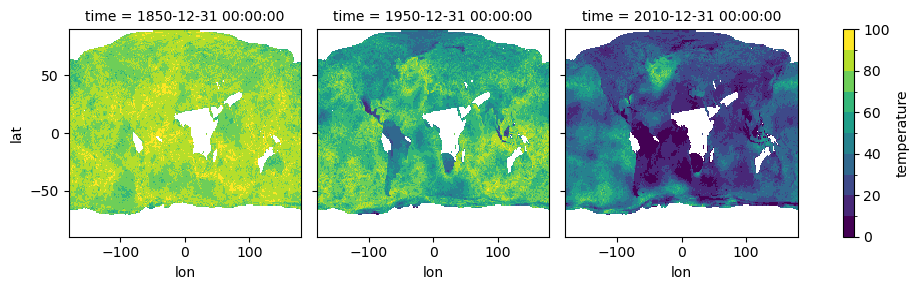

In [72]:
perkins_ds.isel(time=[0, 100, 160]).plot(col='time', levels=np.arange(0, 110, 10))

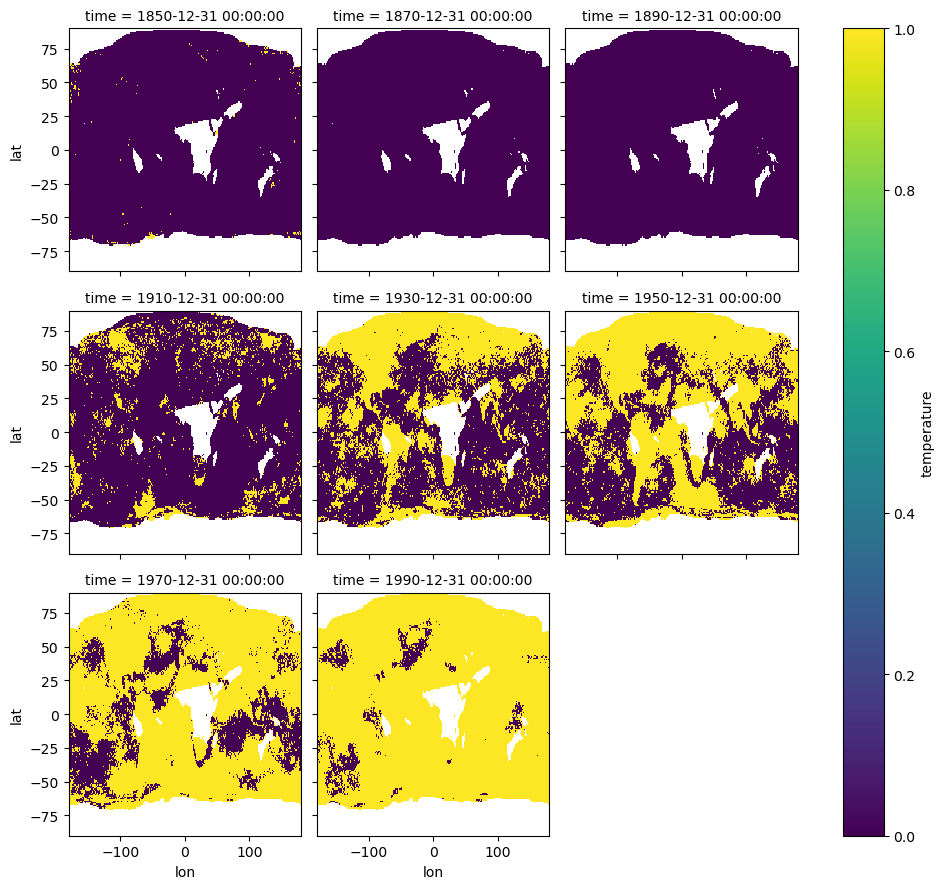

In [73]:
(xr.where(perkins_ds < 66, 1, 0)
 .where(data_availability_mask)
 .isel(time=np.arange(0, 160, 20))
 .plot(col='time', col_wrap=3))

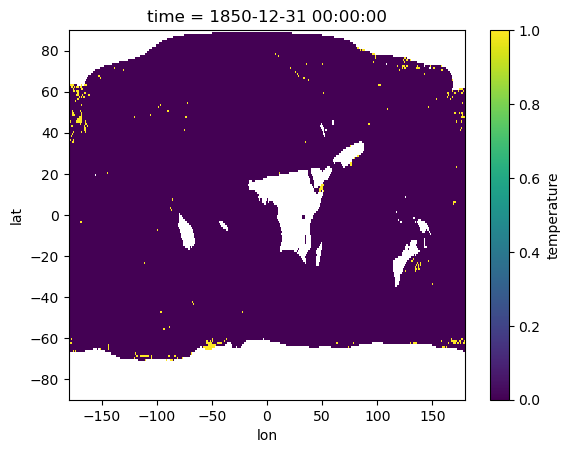

In [74]:
xr.where(perkins_ds.isel(time=0) < 66, 1, 0).where(data_availability_mask).plot()

In [87]:
perkins_toe_ds = toe.get_permanent_exceedance(perkins_ds, threshold=62, comparison_func=np.less_equal)

In [88]:
frac_geom_toe_ds = toe.get_permanent_exceedance(frac_geom_ds, threshold=62, comparison_func=np.less_equal)

In [89]:
perkins_does_not_emerge = (perkins_ds.isel(time=-1) >= 62)

In [90]:
frac_geom_ds_does_not_emerge = (frac_geom_ds.isel(time=-1) >= 62)

In [91]:
import matplotlib.colors as mcolors

In [92]:
# Create a custom colormap with two colors: gray and transparent
colors = [(0, 0, 0, 0), (0.5, 0.5, 0.5, 1)]  # (R, G, B, Alpha)
cmap_binary = mcolors.LinearSegmentedColormap.from_list("binary_no_color", colors)

In [93]:
not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
not_stable_kwargs = dict(add_colorbar=False, hatches=['', '////'], alpha=0, colors=None)

In [94]:
def hatch(ax, ds, **kwargs):
    LON, LAT = np.meshgrid(ds.lon.values, ds.lat.values)
    ax.contourf(LON, LAT, ds.values, **kwargs)

In [95]:
data_unavailability_mask = xr.where(data_availability_mask, False, True)

Text(0.5, 1.0, 'Perkins Skill Score (<62%)')

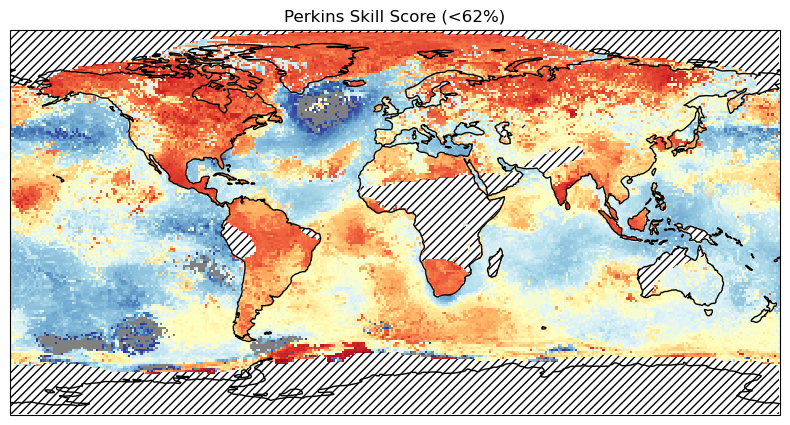

In [96]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
perkins_toe_ds.plot(ax=ax, cmap='RdYlBu', add_colorbar=False)#, levels=np.arange(1860, 2030, 10))


perkins_does_not_emerge.plot(ax=ax, **not_stable_kwargs2)
hatch(ax, data_unavailability_mask, **not_stable_kwargs)
ax.coastlines()

ax.set_title('Perkins Skill Score (<62%)')

Text(0.5, 1.0, 'Fractional Gemoetric Ratio (<62%)')

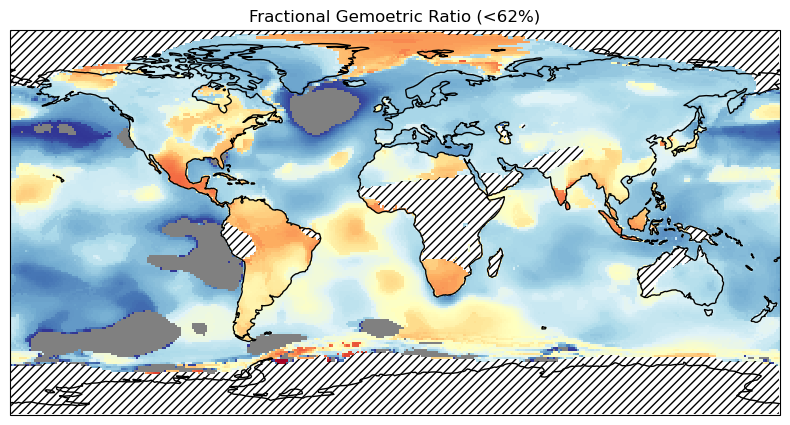

In [97]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
frac_geom_toe_ds.plot(ax=ax, cmap='RdYlBu', add_colorbar=False)#, levels=np.arange(1860, 2030, 10))


frac_geom_ds_does_not_emerge.plot(ax=ax, **not_stable_kwargs2)
hatch(ax, data_unavailability_mask, **not_stable_kwargs)
ax.coastlines()

ax.set_title('Fractional Gemoetric Ratio (<62%)')